<a href="https://colab.research.google.com/github/amirebm/ML-Implementation/blob/master/captum_integrated_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.digitalocean.com/community/tutorials/model-interpretability-and-understanding-for-pytorch-using-captum

In [3]:
! conda install pytorch torchvision captum -c pytorch
! pip install torch torchvision captum


/bin/bash: line 1: conda: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.6 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import LayerGradCam
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import LayerAttribution

#Loads pretrained Resnet model and sets it to eval mode

In [5]:
model = models.resnet18(pretrained=True)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


#The ResNet is trained on the ImageNet data-set. Downloads and reads the list of ImageNet dataset classes/labels in memory.

In [7]:
! wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

--2024-11-23 17:38:10--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.35.176, 3.5.17.98, 52.217.162.104, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.35.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2024-11-23 17:38:10 (1.74 MB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



**Your image folder must contain the file cat.jpg. As we can see below, Image.open() opens and identifies the given image file and np.asarry() converts it to an array.**

Mounted at /content/drive


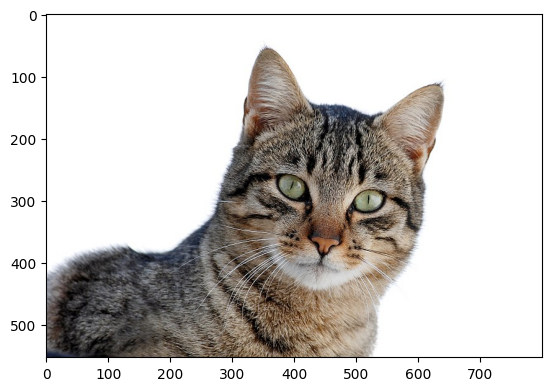

In [10]:
from google.colab import drive
drive.mount('/content/drive')
test_img = Image.open('/content/drive/My Drive/Colab Notebooks/Image_net/cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

In the code below, we will define transformers and normalizing functions for the image. To train our ResNet model, we used the ImageNet dataset, which requires images to be of a particular size, with channel data normalized to a specified range of values. transforms.**Compose**() composes several transforms together and transforms.**Normalize**() normalizes a tensor image with mean and standard deviation.

In [11]:
# model expectation is 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224), #crop the given tensor image at the center
 transforms.ToTensor()
])
# ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/content/drive/My Drive/Colab Notebooks/Image_net/cat.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
#unsqueeze returns a new tensor with a dimension of size one inserted at the #specified position.
input = input.unsqueeze(0)

In [17]:
import json
import urllib.request

# Load ImageNet class labels (simple list of strings)
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
response = urllib.request.urlopen(url)
labels = json.loads(response.read())

# Create idx_to_labels
idx_to_labels = {str(i): label for i, label in enumerate(labels)}


**Now, we will predict the class of the input image. The question that can be asked is, “What does our model feel this image represents?”**

In [18]:
# Run model inference
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()

# Access the predicted label directly
predicted_label = labels[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: tabby cat ( 0.5724196434020996 )


In [19]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
#Create IntegratedGradients object and get attributes
integrated_gradients = IntegratedGradients(model)
#Request the algorithm to assign our output target to
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

Predicted: tabby cat ( 0.5724196434020996 )


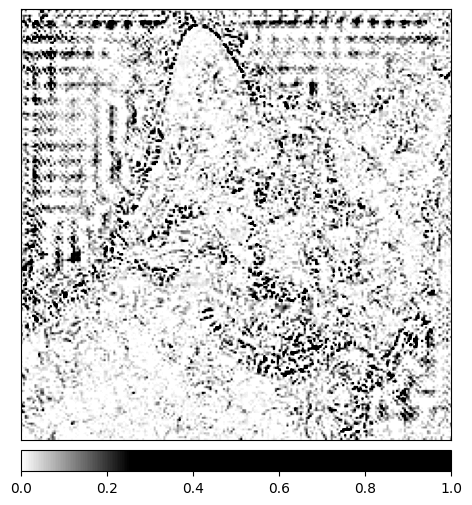

In [20]:
#result visualization with custom colormap
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
# use visualize_image_attr helper method for visualization to show the #original image for comparison
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

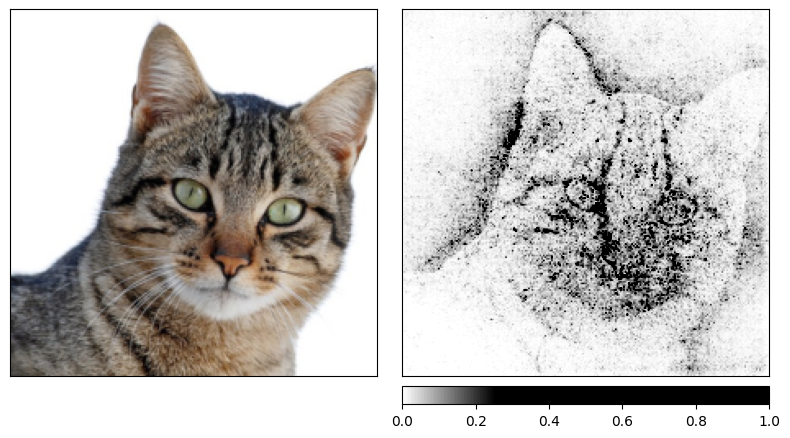

In [21]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

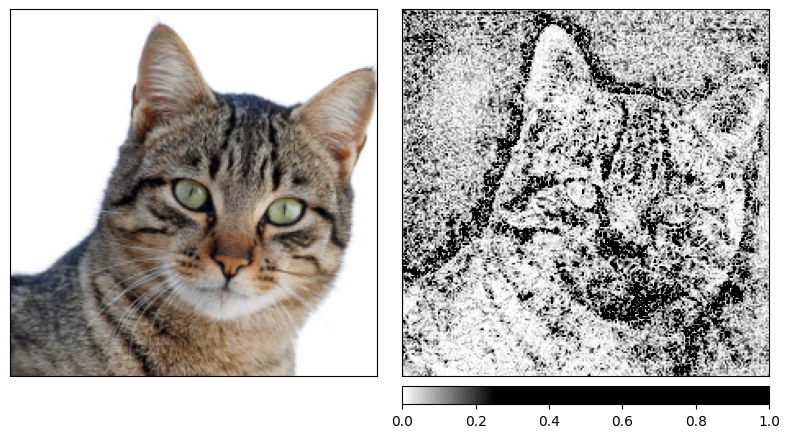

In [22]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Definition of baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

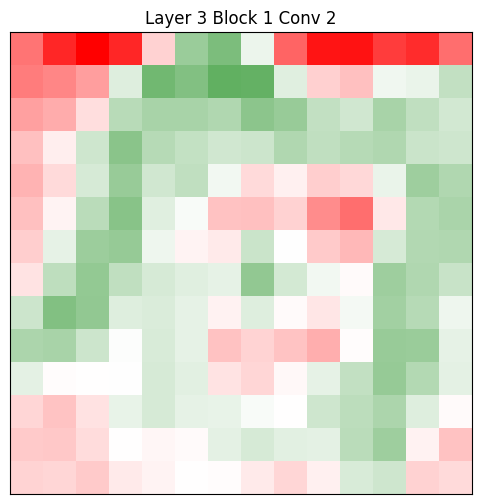

In [23]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")

**To make a more accurate comparison between the input image and this attribution data, we will upsample it with the help of the function interpolate(), located in the LayerAttribution base class.**

torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


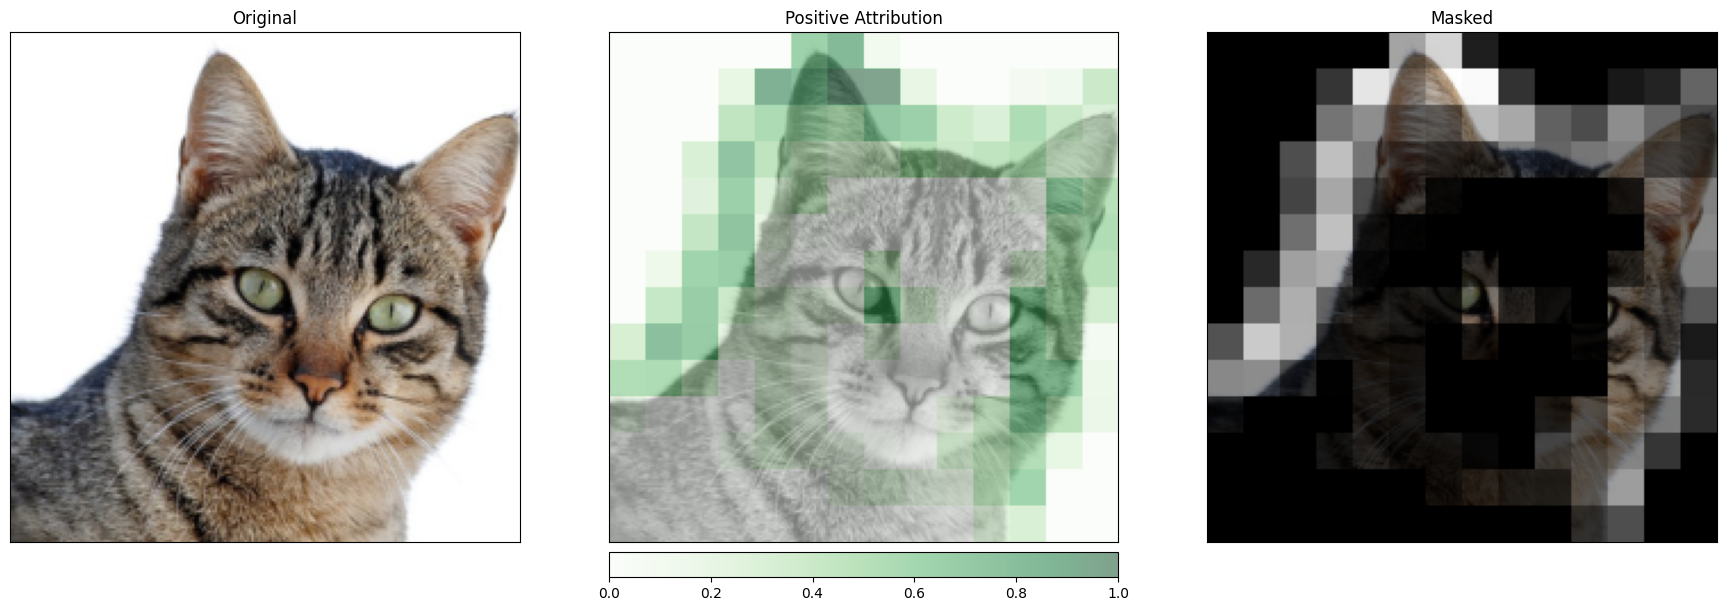

In [24]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

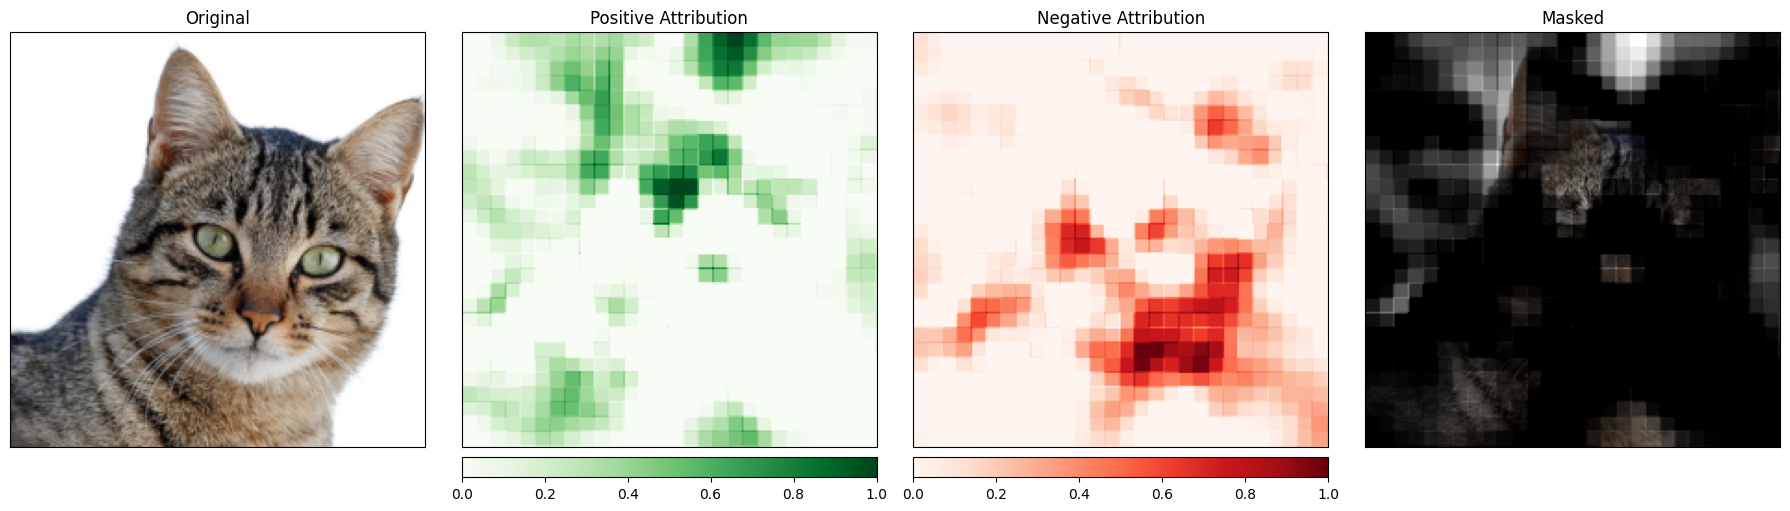

In [25]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )